## 📚 1 - Importing Libraries
First, let's run the cell below to import all the packages that you will need during this project.

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, AveragePooling2D, Input, Add, Flatten, GlobalMaxPooling2D, MaxPooling2D, Activation, ZeroPadding2D, MaxPool2D
from tensorflow.keras.initializers import glorot_uniform as gu
from tensorflow.keras.initializers import random_uniform as ru
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


: 

## 📦 2. Create the Dataset and Split it into Training and Validation Sets

In [69]:
batch_size = 16
img_size = (112, 112)
directory = "DataSet/raw-img"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle = False, 
                                             batch_size = batch_size,
                                             image_size = img_size,
                                             label_mode = "categorical",
                                             validation_split = 0.3, 
                                             subset = "training",
                                             seed = 27)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle = False, 
                                             batch_size = batch_size,
                                             image_size = img_size,
                                             label_mode = "categorical",
                                             validation_split = 0.3, 
                                             subset = "validation",
                                             seed = 27)                                             

Found 26179 files belonging to 10 classes.
Using 18326 files for training.
Found 26179 files belonging to 10 classes.
Using 7853 files for validation.


## 2.1 Understanding train_dataset Structure

Image shape: (112, 112, 3)
Label shape: (10,)
Image data type: <dtype: 'float32'>
Label data type: <dtype: 'float32'>


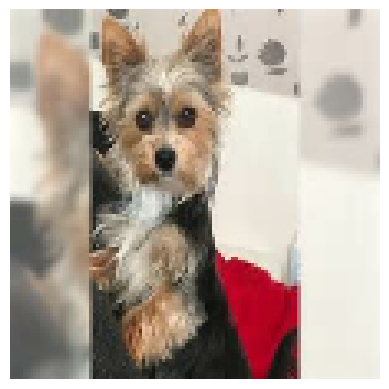

Label (one-hot encoded): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class index: 0
Class name: cane


In [70]:
# Take one batch from the dataset
for images, labels in train_dataset.take(1):
    # Extract the first image and label from the batch
    image = images[0]
    label = labels[0]

    # Check shapes and types
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)
    print("Image data type:", image.dtype)
    print("Label data type:", label.dtype)

    # Display the image
    image_np = image.numpy().astype("uint8")
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

    # Print the label
    print("Label (one-hot encoded):", label.numpy())

    # Get class index and name
    class_index = np.argmax(label.numpy())
    class_names = train_dataset.class_names
    print("Class index:", class_index)
    print("Class name:", class_names[class_index])

In [71]:
def identity_block(X, filters, block, level, initializer = ru ):

    # Generate name for each layer 
    cname = f"CONV{level}.{block}" + "{layer}.{type}"
    
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X

# Main Path
    # First part of identity block
    X = Conv2D( filters = F1,
                kernel_size = (1,1),
                strides = (1,1),
                padding = 'valid',
                name = cname.format(layer = 1, type = 'Conv'),
                kernel_initializer = initializer(seed = 0)
    )(X)
    X = BatchNormalization(axis = 3, name = cname.format(layer = 1 , type = 'BN'))(X)
    X = Activation('relu', name = cname.format(layer = 1, type = 'Relu'))(X)

    # Second part of identity block
    X = Conv2D( filters = F2,
                kernel_size = (3,3),
                strides = (1,1),
                padding = 'same',
                name = cname.format(layer = 2, type = 'Conv'),
                kernel_initializer = initializer(seed = 0)
    )(X)
    X = BatchNormalization(axis = 3, name = cname.format(layer = 2 , type = 'BN'))(X)
    X = Activation('relu', name = cname.format(layer = 2, type = 'Relu'))(X)

    # Third part of identity block
    X = Conv2D( filters = F3,
                kernel_size = (1,1),
                strides = (1,1),
                padding = 'valid',
                name = cname.format(layer = 3, type = 'Conv'),
                kernel_initializer = initializer(seed = 0)
    )(X)
    X = BatchNormalization(axis = 3, name = cname.format(layer = 3 , type = 'BN'))(X)

# Add Shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu', name = cname.format(layer = 3, type = 'Relu'))(X)

    return X

In [72]:
def convolutional_block(X, filters, f, block, level, s = 2, initializer = gu):

    # Generate name for each layer 
    cname = f"CONV{level}.{block}" + "{layer}.{type}"
    
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X

# Main Path
    # First part of convolutional block
    X = Conv2D( filters = F1,
                kernel_size = (1,1),
                strides = s,
                padding = 'valid',
                name = cname.format(layer = 1, type = 'Conv'),
                kernel_initializer = initializer(seed = 0)
    )(X)
    X = BatchNormalization(axis = 3, name = cname.format(layer = 1 , type = 'BN'))(X)
    X = Activation('relu', name = cname.format(layer = 1, type = 'Relu'))(X)

    # Second part of convolutional block
    X = Conv2D( filters = F2,
                kernel_size = (f,f),
                strides = (1,1),
                padding = 'same',
                name = cname.format(layer = 2, type = 'Conv'),
                kernel_initializer = initializer(seed = 0)
    )(X)
    X = BatchNormalization(axis = 3, name = cname.format(layer = 2 , type = 'BN'))(X)
    X = Activation('relu', name = cname.format(layer = 2, type = 'Relu'))(X)

    # Third part of convolutional block
    X = Conv2D( filters = F3,
                kernel_size = (1,1),
                strides = (1,1),
                padding = 'valid',
                name = cname.format(layer = 3, type = 'Conv'),
                kernel_initializer = initializer(seed = 0)
    )(X)
    X = BatchNormalization(axis = 3, name = cname.format(layer = 3 , type = 'BN'))(X)

    # Shortcut Path
    X_shortcut = Conv2D( filters = F3,
                         kernel_size = (1,1), 
                         strides = s,
                         padding = 'valid',
                         name = cname.format(layer = 'Shortcut', type = 'Conv'),
                         kernel_initializer = initializer(seed = 0)
    )(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = cname.format(layer = 'Shortcut', type = 'BN'))(X_shortcut)

# Add Shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu', name = cname.format(layer = 3, type = 'Relu'))(X)

    return X

In [73]:
def ResNet50(input_size = (112, 112, 3), classes = 10, training = False):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_size)

    # Zero-padding
    X = ZeroPadding2D((3,3), name = "ZeroPadding")(X_input)

    # Conv1
    X = Conv2D( filters = 64, 
                kernel_size = (7,7),
                strides = (2,2),
                name = 'Conv_init',
                kernel_initializer = gu(seed = 0)
    )(X)
    X = BatchNormalization(axis = 3, name = 'Conv1_1_1_NB')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (3,3), strides = (2,2), name = 'Pool_init')(X)


    # Conv2
    X = convolutional_block(X, f = 3, level = 2, block = 1, filters = (64, 64, 256), s = 2)
    X = identity_block(X, level = 2, block = 2, filters = (64, 64, 256))
    X = identity_block(X, level = 2, block = 3, filters = (64, 64, 256))


    # Conv3
    X = convolutional_block(X, f = 3, level = 3, block = 1, filters = (128, 128, 512), s = 2)
    X = identity_block(X, level = 3, block = 2, filters = (128, 128, 512))
    X = identity_block(X, level = 3, block = 3, filters = (128, 128, 512))
    X = identity_block(X, level = 3, block = 4, filters = (128, 128, 512))


    # Conv4
    X = convolutional_block(X, f = 3, level = 4, block = 1, filters = (256, 256, 1024), s = 2)
    X = identity_block(X, level = 4, block = 2, filters = (256, 256, 1024))
    X = identity_block(X, level = 4, block = 3, filters = (256, 256, 1024))
    X = identity_block(X, level = 4, block = 4, filters = (256, 256, 1024))
    X = identity_block(X, level = 4, block = 5, filters = (256, 256, 1024))
    X = identity_block(X, level = 4, block = 6, filters = (256, 256, 1024))
                

    # Conv5
    X = convolutional_block(X, f = 3, level = 5, block = 1, filters = (512, 512, 2048), s = 2)
    X = identity_block(X, level = 5, block = 2, filters = (512, 512, 2048))
    X = identity_block(X, level = 5, block = 3, filters = (512, 512, 2048))


    # Penaltimate Layers
    X = AveragePooling2D(pool_size = (2,2), name = 'Avg_Pool')(X)
    X = Flatten()(X)

    # Output Layer
    X = Dense(units = classes, activation = 'softmax', name = 'Final', kernel_initializer = gu(seed = 0))(X)


    # Create Model
    model = Model(inputs = X_input , outputs = X, name = 'ResNet50')

    return model

In [74]:
model = ResNet50(input_size = (112, 112, 3), classes = 10)

In [75]:
model.summary(line_length = 96)

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 112, 112, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ZeroPadding               │ (None, 118, 118, 3)    │              0 │ input_layer_13[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv_init (Conv2D)        │ (None, 56, 56, 64)     │          9,472 │ ZeroPadding[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_1_1_NB              │ (None, 56, 56, 64)     │            256 │ Conv_init[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_13             │ (None, 56, 56, 64)     │              0 │ Conv1_1_1_NB[0][0]     │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool_init (MaxPooling2D)  │ (None, 27, 27, 64)     │              0 │ activation_13[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CONV2.11.Conv (Conv2D)    │ (None, 14, 14, 64)     │          4,160 │ Pool_init[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CONV2.11.BN               │ (None, 14, 14, 64)     │            256 │ CONV2.11.Conv[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CONV2.11.Relu             │ (None, 14, 14, 64)     │              0 │ CONV2.11.BN[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CONV2.12.Conv (Conv2D)    │ (None, 14, 14, 64)     │         36,928 │ CONV2.11.Relu[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CONV2.12.BN               │ (None, 14, 14, 64)     │            256 │ CONV2.12.Conv[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CONV2.12.Relu             │ (None, 14, 14, 64)     │              0 │ CONV2.12.BN[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CONV2.1Shortcut.Conv      │ (None, 14, 14, 256)    │         16,640 │ Pool_init[0][0]        │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CONV2.13.Conv (Conv2D)    │ (None, 14, 14, 256)    │         16,640 │ CONV2.12.Relu[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CONV2.1Shortcut.BN        │ (None, 14, 14, 256)    │          1,024 │ CONV2.1Shortcut.Conv[… │
│ (BatchNormalization) 

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [76]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [78]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=3,            # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,       # Minimum change in the monitored metric to qualify as an improvement
    verbose=1,             # Verbosity mode
    mode='min',            # Direction for optimization ('min' or 'max')
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)


In [79]:
history = model.fit(train_dataset, validation_data = validation_dataset, epochs = 30, callbacks=[early_stopping])

Epoch 1/30
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 518s 432ms/step - accuracy: 0.9689 - loss: 0.6612 - val_accuracy: 0.1449 - val_loss: 46.9313
Epoch 2/30
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 489s 427ms/step - accuracy: 0.8399 - loss: 0.9614 - val_accuracy: 0.1490 - val_loss: 18.9271
Epoch 3/30
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 493s 430ms/step - accuracy: 0.9026 - loss: 0.5984 - val_accuracy: 0.1490 - val_loss: 91.1163
Epoch 4/30
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 494s 431ms/step - accuracy: 0.8908 - loss: 0.6471 - val_accuracy: 0.1490 - val_loss: 9723.0420
Epoch 5/30
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 496s 433ms/step - accuracy: 0.9018 - loss: 0.7001 - val_accuracy: 0.1490 - val_loss: 2548.4463
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
